<a href="https://colab.research.google.com/github/YosukeSugiura/-_-/blob/main/%E6%BC%94%E7%BF%92%E8%AA%B2%E9%A1%8C%EF%BC%92%EF%BC%9AWhisper%E3%81%AB%E3%82%88%E3%82%8B%E9%9F%B3%E5%A3%B0%E8%AA%8D%E8%AD%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Public URL
**https://2c5b4cce9aa67f1c1c.gradio.live**

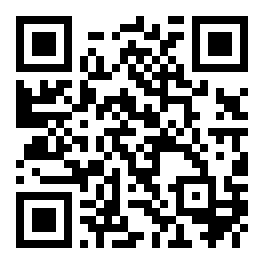

In [5]:
# =========================
# Whisper-base による音声認識（CPU固定・WAVアップロードのみ・日本語）
# =========================

!pip -q install -U "gradio==5.47.2" "faster-whisper==1.0.3" soundfile librosa soxr > /dev/null

import os, time, tempfile
import numpy as np
import soundfile as sf
import librosa
import gradio as gr
from faster_whisper import WhisperModel

# ---- ASRモデル（base / CPU固定 / 多言語版）----
_model = None
def get_model():
    global _model
    if _model is None:
        # ※ "base" は多言語モデル。日本語は language="ja" で固定する
        _model = WhisperModel("base", device="cpu", compute_type="int8")
    return _model

# ---- 16 kHz mono へ正規化 ----
def ensure_wav_16k_mono(path: str):
    y, sr = sf.read(path)
    if y.ndim > 1:
        y = y[:,0]
    if sr != 16000:
        y = librosa.resample(y, orig_sr=sr, target_sr=16000, res_type="soxr_hq")
        sr = 16000
    y = y.astype(np.float32)
    tmp = tempfile.NamedTemporaryFile(delete=False, suffix=".wav")
    sf.write(tmp.name, y, sr)
    return tmp.name

def safe_path(ui_audio):
    if ui_audio is None:
        return None
    if isinstance(ui_audio, dict) and "name" in ui_audio:
        return ui_audio["name"]
    if isinstance(ui_audio, str):
        return ui_audio
    if isinstance(ui_audio, list) and ui_audio and isinstance(ui_audio[0], dict) and "name" in ui_audio[0]:
        return ui_audio[0]["name"]
    return None

# ---- 音声認識（日本語固定） ----
def transcribe_file(path: str):
    wav = ensure_wav_16k_mono(path)
    model = get_model()
    t0 = time.time()
    segments, info = model.transcribe(
        wav, language="ja", vad_filter=True
    )
    text = "".join([seg.text for seg in segments]).strip()
    elapsed = time.time() - t0
    return text, elapsed, info.duration

# ---- Gradio UI ----
with gr.Blocks() as demo:
    gr.Markdown("## Whisper-baseによる音声認識")

    with gr.Row():
        with gr.Column():
            audio = gr.Audio(label="WAVファイル(アップロード)", sources=["upload"], type="filepath")
            run = gr.Button("認識する", variant="primary")
        with gr.Column():
            out_text = gr.Textbox(label="認識結果テキスト", lines=6)
            out_time = gr.Markdown()  # ← LabelではなくMarkdownに変更（文字可）

    def do_asr(ui_audio):
        p = safe_path(ui_audio)
        if not p or not os.path.exists(p):
            return "⚠️ WAVファイルをアップロードしてください。", "処理時間: - / 音声長: -"
        text, sec, dur = transcribe_file(p)
        tinfo_md = f"**処理時間:** {sec:.2f}s　/　**音声長:** {dur:.2f}s"
        return text, tinfo_md

    run.click(do_asr, inputs=[audio], outputs=[out_text, out_time])

res = demo.queue().launch(share=True, inline=False, show_error=True)

# --- URL と QR のみ表示（Gradio 版数差吸収） ---
from IPython.display import clear_output, display, Markdown, Image
clear_output(wait=True)

url = getattr(res, "share_url", None) or getattr(res, "public_url", None)
if url is None:
    try:
        _, _, url = res  # older tuple
    except Exception:
        url = None

if not url:
    print("No share URL.")
else:
    try:
        import segno
    except Exception:
        import sys, subprocess
        subprocess.run([sys.executable, "-m", "pip", "-q", "install", "segno"], check=False)
        import segno
    qr_path = "/content/gradio_url_qr.png"
    segno.make(url).save(qr_path, scale=8, border=2)
    display(Markdown(f"### Public URL\n**{url}**"))
    display(Image(qr_path))
